# Iteratively re-weighted least squares (IRLS) compressed sensing algorithm


Based on the archived [Julia V0.4](https://github.com/dahlend/CompressedSensing.jl) implentation of 
Equality constrained Iteratively Reweighted Least Squares (IRLS) Lp Minimization.[1](www.sciencedirect.com/science/article/pii/S092523121300430X)

A working Julia V1.1 implementation can also be found [here](https://github.com/tmellan/CompressedSensingJuliaV1).


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

### Make a sparse signal to test 
Uniform random distributed sparse signal, with normal intensities.

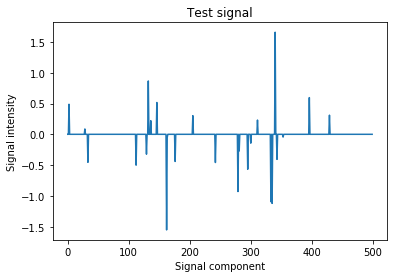

In [39]:
n=500  #Signal Dimensions
m=200  #Measurement Dimension
k=25;  #Approximate Sparsity

Signal = np.zeros(n)
RandIntSelection = (np.random.uniform(0,1,k)*(n-1)+np.ones(k)).astype(int)
Signal[RandIntSelection] = np.random.normal(0,1,k)
plt.plot(Signal)
plt.title('Test signal')
plt.xlabel('Signal component')
plt.ylabel('Signal intensity')
plt.show()

### Create a Measurement of the signal with a random sensing function
##### Measurement = SensingFunction * Signal
As a test case, the original sparse signal (k=25) will be recovered, using fewer measurements (m=200) than total components of the signal (n=500). 

Compressed sensing: "... with an overwhelming probability, any sparse signal with k nonzero components can be recovered from m ∼ k ln(n) random measurements, where n is the total number of sensing basis functions."

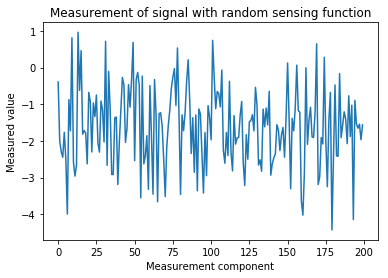

In [46]:
MM = np.random.uniform(0,1,[m,n]) #Random measurement matrix
Measurement = np.matmul(MM,Signal) #Measurement = MeasurementMatrix * Signal
plt.plot(Measurement)
plt.title('Measurement of signal with random sensing function')
plt.ylabel('Measured value')
plt.xlabel('Measurement component')
plt.show()

### Confirm signal can't be recovered trivially from the undetermined system using standard methods (e.g. Moore-Penrose pseudoinverse)
##### Signal ≠ Pseudo-inverse (SensingFunction) * Measurement

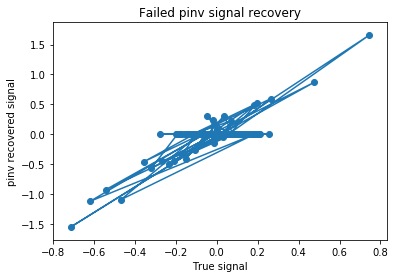

In [59]:
#pinv from LinearAlgebra library
#Perfect recovery would give a straight line bisecting -- to ++. 
MM_moorepenrose_pinv  = np.linalg.pinv(MM)
moorePenrose_recovered_signal = np.matmul(MM_moorepenrose_pinv,Measurement)
plt.plot(moorePenrose_recovered_signal,Signal)
plt.scatter(moorePenrose_recovered_signal,Signal)
plt.title('Failed pinv signal recovery')
plt.ylabel('pinv recovered signal')
plt.xlabel('True signal')
plt.show()

### IRLS algorithm to recover compressed sensing solution

In [15]:
##################
#Support functions
##################
def findSol(Y,A,M,Mt):
    return A-np.matmul(Mt,np.matmul(M,A)-Y)

def initSolution(MeasurementMatrix,MeasuredOutput,m):
    #Guess a random solution
    GuessedInput=np.zeros(m)
    GuessedInput[(np.random.uniform(0,1,round(m/10))*(m-1)+np.ones(round(m/10))).astype(int)] = np.random.uniform(0,1,round(m/10))

    #project the guessed solution into the space of exact answers
    GuessedInput=findSol(MeasuredOutput,
        GuessedInput,
        MeasurementMatrix,
        np.linalg.pinv(MeasurementMatrix))
    return GuessedInput

def plusOp(x):
    x.clip(min=0)

#function soft(x,l)
#    sign(x).*plusOp(abs(x)-l)
#end

#############################################
#Iteratively re-weighted least squares (IRLS)
#############################################
def IRLS(MeasurementMatrix,MeasuredOutput,verbose="false",maxiter=1000,p=.5,threshold=1e-7,debug="false"):

#Smooth
    eps=lambda eps : 1/eps**3
    
# identify the size of the input
    m=MeasurementMatrix.shape[1]
    
# First we need to calculate a valid solution
    GuessedInput = initSolution(MeasurementMatrix,MeasuredOutput,m)
    
###### Initialize some values used in the IRLS algorithm ############
#Construct the weight matrix, used in the ridge regression
    wn = np.zeros([m,m])
    
#Save a copy of the "previous" guess, which in this case is the original guess
    PrevGuess=GuessedInput

#transpose the sampling matrix, this is used every iteration so it
#is far more efficient to calculate it before hand.  
    tMeasurementMatrix=MeasurementMatrix.transpose()
    
#set the distance between iterations to infinite    
    PrevDist = np.full(round(maxiter/100 + 1), np.inf)
    
#start on iteration 1
    iteration=1
    if verbose == "true":
        print("Iteration: \n", iteration)
          
#assume we are converging, this will be set to false if neccessary
    converges="true"
    
    debugCounter = 0
    if debug == "true":
        print("\n 1."+str(debugCounter)+" Starting while loop")

    while PrevDist[round(iteration/100)] > threshold:
        
        debugCounter +=1

        if debug == "true":
            print("\n 1."+str(debugCounter)+" Starting for loop for wn")
            
        for j in range(0,m):
            wn[j,j] = 1. / (GuessedInput[j]**2  + eps(iteration))**(p/2. - 1.)
            
        if debug == "true":
            print("\n 2."+str(debugCounter)+" Ended for loop for wn")
        
        PrevGuess=GuessedInput
        
        if debug == "true":
            print("\n 3."+str(debugCounter)+" PrevGuess set as GuessInput\n Starting IRLS step")
    
#        #IRLS step
#        GuessedInput=wn*tMeasurementMatrix*
#        pinv(MeasurementMatrix*wn*tMeasurementMatrix)*
#        MeasuredOutput
            
        wntMeasurementMatrix = np.matmul(wn,tMeasurementMatrix)  
        MMwntMMpinv = np.linalg.pinv(np.matmul(MeasurementMatrix, wntMeasurementMatrix))  
        GuessedInput = np.matmul(wntMeasurementMatrix,np.matmul(MMwntMMpinv,MeasuredOutput))
        
        if debug == "true":
            print("\n 4."+str(debugCounter)+" Ending IRLS step")
       
        if iteration % (maxiter/100) == 1:
        
        #Measure Euclidean distance between answers  
            PrevDist[round(iteration/100)+1] = np.sqrt(np.sum(np.square(PrevGuess-GuessedInput)))/m
        
            if verbose == "false":
                print("\n"+str(iteration)+ "Euclidean Distance between steps: "+str(PrevDist[int(round(iteration/100)+1)]) )
        
        #most involved convergence test, see if the distance increases from one iteration
        #to the next, and if it does, break, converges=false since we didn't hit threshold
            if ((round(iteration/100)+1>2) and (PrevDist[round(iteration/100)+1] > PrevDist[max(round(iteration/100)+1,1)])):
                converges="false"
                break
            
        #if we pass maxiter iterations, give up
            if iteration>=maxiter:
                converges="false"
                break
            
        iteration+=1
            
    if verbose == "true":
        print("Completed Iteration: \n", iteration)
            
    #if debugging, return additional information, such as distance to convergence and iteration number
    if debug == "true":
        return (GuessedInput,converges,iteration-1,PrevDist[0:int(iteration/100)+1])
#       print(GuessedInput,converges,iteration-1,PrevDist[0:int(iteration/100)+1])
    else:
        return GuessedInput
#       print(GuessedInput)
    


### Recover signal in debug mode

In [61]:
IRLS(MM,Measurement,verbose="true",maxiter=5000,p=.5,threshold=1e-7,debug="true")

Iteration: 
 1
Completed Iteration: 
 150


array([-1.53091051e-05, -6.93485047e-07,  4.87721847e-01, -6.72530684e-06,
        1.71410719e-05,  8.23116351e-06, -6.07026813e-06, -2.81673548e-06,
       -1.67121914e-05, -1.06100199e-05,  4.43042849e-06, -5.26820109e-06,
        1.20977124e-05,  4.73504666e-06, -7.47139270e-06, -5.81290331e-06,
       -1.44731890e-06, -3.68944772e-06, -7.23881025e-06,  1.74141315e-05,
       -8.43682120e-06,  1.17385738e-05,  3.06840178e-06,  1.27185976e-05,
       -7.56136744e-08,  7.31279033e-06, -3.00909207e-06,  6.23214979e-06,
        8.67613722e-02,  4.46177260e-06,  1.03150615e-05,  1.40235383e-05,
        7.21163383e-06, -4.54449211e-01,  1.03055165e-06, -1.90086311e-06,
        3.96880100e-07, -2.46202976e-06, -9.30889355e-06, -1.27561217e-05,
        1.40407140e-05,  7.22128441e-06,  6.01217129e-06,  4.38441466e-06,
        1.44338074e-05,  1.86249118e-06, -5.46313040e-06, -5.83196903e-07,
       -6.69621227e-06,  8.25309998e-06,  6.61555320e-06, -1.82547884e-05,
        1.27054827e-05,  

### Recover signal and plot against original signal 

In [62]:
recoveredSignal_IRLS = IRLS(MM,Measurement,verbose="true")

Iteration: 
 1
Completed Iteration: 
 150


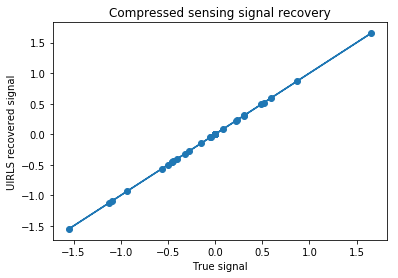

In [63]:
plt.scatter(recoveredSignal_IRLS,Signal) #Perfect recovery would give a straight line bisecting -- to ++. 
plt.plot(recoveredSignal_IRLS,Signal)
plt.title('Compressed sensing signal recovery')
plt.ylabel('UIRLS recovered signal')
plt.xlabel('True signal')
plt.show()